In [1]:
from nais.utils import remove_bad_data
import xarray as xr

ds = xr.open_dataset("nais1_dataset.nc")
bad_data = xr.open_dataset("bad_data_bounds.nc")
ds = remove_bad_data(ds, bad_data)

In [2]:

nais_pos_particles = ds['pos_particles']

In [4]:
nais_pos_particles = nais_pos_particles.to_dataframe(name='particles').reset_index()
nais_pos_particles

,time,diameter,particles
0,2024-05-16,8.028800e-10,NaN
1,2024-05-16,8.628290e-10,NaN
2,2024-05-16,9.272542e-10,NaN
3,2024-05-16,9.961534e-10,NaN
4,2024-05-16,1.070172e-09,NaN
...,...,...,...
344570,2025-02-01,3.063141e-08,4921.901503
344571,2025-02-01,3.302483e-08,6084.146640
344572,2025-02-01,3.560527e-08,7744.249346
344573,2025-02-01,3.846420e-08,9296.937615


In [5]:
# Unstack the particles dimension to get a DataFrame with the diameter as columns
nais_pos_particles = nais_pos_particles.pivot(index='time', columns='diameter', values='particles')
nais_pos_particles

diameter,8.028800e-10,8.628290e-10,9.272542e-10,9.961534e-10,1.070172e-09,1.151195e-09,1.238353e-09,1.330049e-09,1.428535e-09,1.535309e-09,...,2.107146e-08,2.268812e-08,2.445574e-08,2.636108e-08,2.841614e-08,3.063141e-08,3.302483e-08,3.560527e-08,3.846420e-08,4.155270e-08
time,,,,,,,,,,,,,,,,,,,,,
2024-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5569.386022,5818.297681,5985.596865,6026.877014,6313.385141,8043.043951,9832.804478,12143.224782,14524.407083,15785.331156
2025-01-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6670.259334,7217.000305,7999.913764,9308.262764,10895.869749,12874.185007,14503.938546,15430.285698,16445.193506,16313.950944
2025-01-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7609.469967,8418.538885,9189.833852,10021.773610,10386.221059,11135.068141,12865.675468,14942.223550,17012.556876,17842.719290


In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def lognormal(d, Dpg, Sg, N0):
    """
    Single lognormal mode in dN/dlogD form.
    d   : diameter array (must be in meters!)
    Dpg : geometric mean diameter (m)
    Sg  : geometric standard deviation (dimensionless)
    N0  : total number concentration for this mode
    """
    return (N0 / (np.sqrt(2*np.pi) * np.log(Sg))) * np.exp(
        -((np.log(d) - np.log(Dpg))**2) / (2*(np.log(Sg)**2))
    )


In [37]:
def twomodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02):
    """
    Sum of two lognormal modes:
      Mode 1 ~ nucleation
      Mode 2 ~ Aitken
    """
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02))


In [38]:
def fit_two_modes(d, y):
    """
    Fit a 2-mode lognormal distribution to the data (d, y),
    forcing:
      - Mode1 (nucleation): 1–20 nm
      - Mode2 (Aitken):     20–40 nm
    
    Parameters
    ----------
    d : array of diameters (in meters!)
    y : array of dN/dlogD
    
    Returns
    -------
    popt : array of best-fit parameters [Dpg1, Sg1, N01, Dpg2, Sg2, N02]
    pcov : covariance matrix
    """
    # Convert to numpy arrays
    d = np.asarray(d, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Initial guesses (p0):
    #   - Dpg1 ~ 1.0e-8 (10 nm), Sg1 ~ 1.5, N01 ~ 10 * max(y)
    #   - Dpg2 ~ 3.0e-8 (30 nm), Sg2 ~ 1.5, N02 ~ 10 * max(y)
    p0 = [
        1.0e-8, 1.5, max(y)*10,   # Mode1
        3.0e-8, 1.5, max(y)*10    # Mode2
    ]
    
    # Bounds:
    #   Mode1 (nucleation): Dpg1 in [1e-9, 2e-8]
    #   Mode2 (Aitken):     Dpg2 in [2e-8, 4e-8]
    #   Sg in [1.1, 3.0]
    #   N0 in [1, 1e10] (adjust as needed)
    lower_bounds = [
        1e-9,  1.1, 1,      # Dpg1, Sg1, N01
        2e-8,  1.1, 1       # Dpg2, Sg2, N02
    ]
    upper_bounds = [
        2e-8,  3.0, 1e10,
        4e-8,  3.0, 1e10
    ]
    
    # Fit using curve_fit
    popt, pcov = curve_fit(
        twomodal_lognormal, d, y,
        p0=p0, 
        bounds=(lower_bounds, upper_bounds)
    )
    return popt, pcov


In [39]:
def fit_two_modes_all_times(df, min_points=5):
    """
    Loop over each timestamp (row) in df and fit 2 lognormal modes.
    For each row, ignore columns with NaNs or inf.
    Returns a DataFrame with columns for the best-fit parameters:
      [Dpg1, Sg1, N01, Dpg2, Sg2, N02]
    
    Parameters
    ----------
    df : DataFrame
        index: DateTime
        columns: diameters (in meters)
        values: dN/dlogD
    min_points : int
        minimum number of valid diameter bins required to attempt a fit

    Returns
    -------
    results_df : DataFrame
        index: same as df
        columns: [Dpg1, Sg1, N01, Dpg2, Sg2, N02]
    """
    diameters_all = df.columns.values.astype(float)
    
    results = []
    for t in df.index:
        # Extract the row
        y_row = df.loc[t].values
        
        # Build a mask for finite data
        mask = np.isfinite(y_row)
        
        d_valid = diameters_all[mask]
        y_valid = y_row[mask]
        
        # If not enough points remain, store NaN
        if len(d_valid) < min_points:
            results.append({
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan
            })
            continue
        
        # Attempt the 2-mode fit
        try:
            popt, pcov = fit_two_modes(d_valid, y_valid)
            results.append({
                'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
                'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5]
            })
        except (RuntimeError, ValueError):
            # Fit failed or initial guess was out of bounds
            results.append({
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan
            })
    
    return pd.DataFrame(results, index=df.index)


In [40]:

# Example usage:
fitted_params = fit_two_modes_all_times(nais_pos_particles)
fitted_params.head()


,Dpg1,Sg1,N01,Dpg2,Sg2,N02
time,,,,,,
2024-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
fitted_params

,Dpg1,Sg1,N01,Dpg2,Sg2,N02
time,,,,,,
2024-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-31 20:00:00,1.845999e-09,2.999682,78477.003319,3.899826e-08,2.660186,26053.635642
2025-01-31 21:00:00,2.342170e-09,2.124456,39095.163508,3.617641e-08,2.362168,31075.901770
2025-01-31 22:00:00,3.101061e-09,1.816305,32929.146262,3.914638e-08,2.251896,47250.491563


In [42]:
def plot_two_mode_fit_for_time(df, fitted_df, time, ax=None):
    """
    Plot the measured size distribution (dN/dlogD) vs diameter
    and the two-mode lognormal fit for a single time step.
    
    Parameters
    ----------
    df : DataFrame
        index: DateTime
        columns: diameters (meters)
        values: measured dN/dlogD
    fitted_df : DataFrame
        index: same as df
        columns: [Dpg1, Sg1, N01, Dpg2, Sg2, N02]
    time : Timestamp (row in df)
    ax : matplotlib Axes object (optional)
    
    Returns
    -------
    ax : matplotlib Axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    # Extract the measured data for this time
    if time not in df.index:
        raise ValueError(f"{time} not found in df.index")
    d_all = df.columns.values.astype(float)  # diameters
    y_all = df.loc[time].values  # measured distribution
    
    # Mask out any NaNs
    mask = np.isfinite(y_all)
    d_valid = d_all[mask]
    y_valid = y_all[mask]
    
    # Get fitted parameters
    if time not in fitted_df.index:
        raise ValueError(f"{time} not found in fitted_df.index")
    params = fitted_df.loc[time]
    Dpg1, Sg1, N01, Dpg2, Sg2, N02 = params[['Dpg1', 'Sg1', 'N01', 'Dpg2', 'Sg2', 'N02']]
    
    # If any parameter is NaN, skip plotting the fit
    # or you can choose to show a message
    if np.isnan([Dpg1, Sg1, N01, Dpg2, Sg2, N02]).any():
        ax.scatter(d_valid, y_valid, color='k', label='Measured (some fit params NaN)')
        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlabel('Diameter (m)')
        ax.set_ylabel('dN/dlogD')
        ax.set_title(f'{time} - No valid fit')
        ax.legend()
        return ax
    
    # Generate a fine diameter grid for plotting the fit
    d_fine = np.logspace(np.log10(d_valid.min()/1.2),
                         np.log10(d_valid.max()*1.2),
                         200)
    
    # Compute total fit
    fit_total = twomodal_lognormal(d_fine, Dpg1, Sg1, N01, Dpg2, Sg2, N02)
    # Also compute each mode separately (for illustration)
    fit_mode1 = lognormal(d_fine, Dpg1, Sg1, N01)
    fit_mode2 = lognormal(d_fine, Dpg2, Sg2, N02)
    
    # Plot the measured data
    ax.scatter(d_valid, y_valid, color='k', label='Measured')
    
    # Plot the fitted total
    ax.plot(d_fine, fit_total, color='red', label='2-mode fit (total)')
    
    # Plot each mode separately
    ax.plot(d_fine, fit_mode1, color='blue', linestyle='--', label='Mode 1')
    ax.plot(d_fine, fit_mode2, color='green', linestyle='--', label='Mode 2')
    
    ax.set_xscale('log')
    ax.set_yscale('linear')  # or 'log', depending on your preference
    ax.set_xlabel('Diameter (m)')
    ax.set_ylabel('dN/dlogD')
    ax.set_title(f'2-Mode Fit - {time}')
    ax.legend()
    
    return ax


In [43]:
def plot_fits_for_multiple_times(df, fitted_df, times_list):
    """
    Create subplots for each time in `times_list`, showing 
    measured data and the two-mode fit.
    
    Parameters
    ----------
    df : DataFrame
    fitted_df : DataFrame
    times_list : list of timestamps (subset of df.index)
    """
    n_times = len(times_list)
    fig, axes = plt.subplots(n_times, 1, figsize=(7, 5*n_times), sharex=False)
    
    if n_times == 1:
        # If there's only one time, axes is not a list
        axes = [axes]
    
    for ax, time in zip(axes, times_list):
        plot_two_mode_fit_for_time(df, fitted_df, time, ax=ax)
    
    plt.tight_layout()
    plt.show()


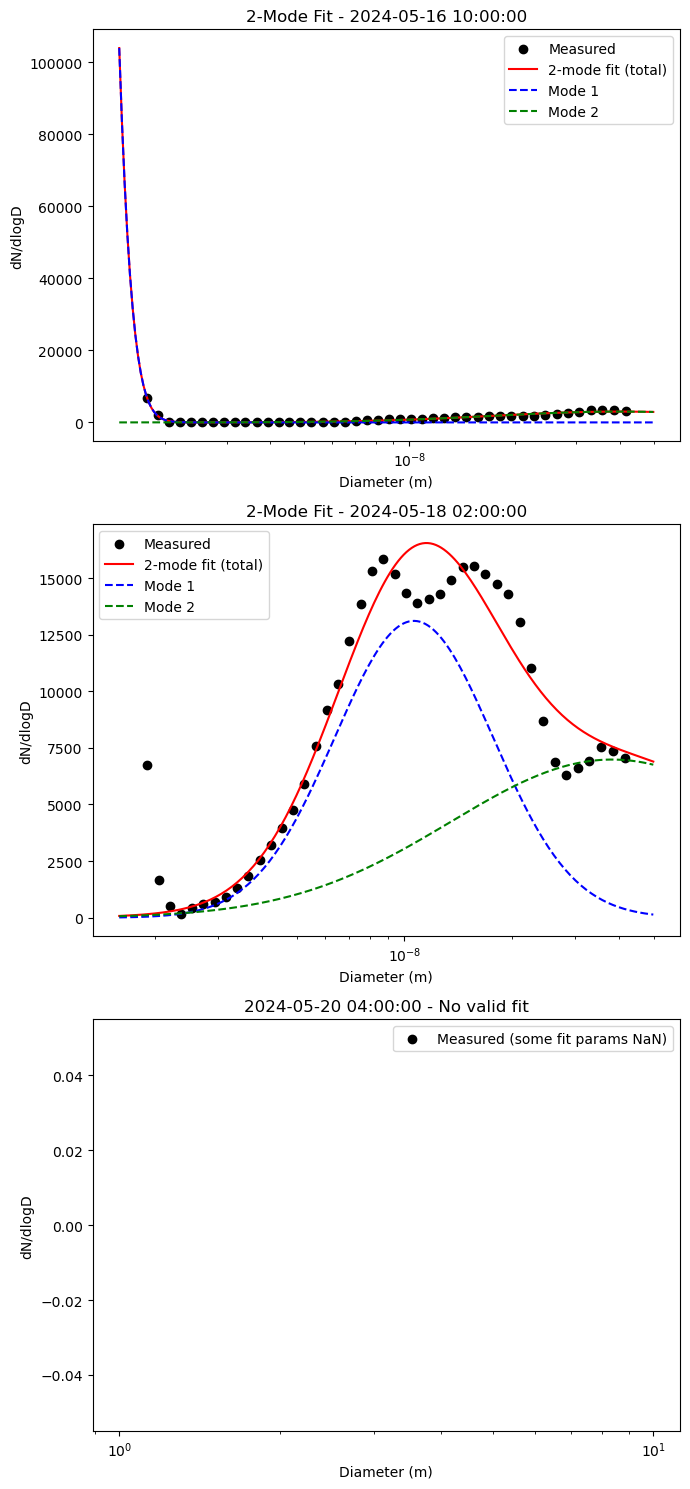

In [44]:
# Suppose 'df' is your size distribution DataFrame
# and 'fitted_df' is the output from fit_two_modes_all_times()

# 1) Pick a few times
#times_to_plot = nais_pos_particles.index[:3]  # first 3 times, for example
# or 
times_to_plot = [nais_pos_particles.index[10], nais_pos_particles.index[50], nais_pos_particles.index[100]]

# 2) Plot
plot_fits_for_multiple_times(nais_pos_particles, fitted_params, times_to_plot)


In [48]:
nais_pos_particles.index[-6:]

DatetimeIndex(['2025-01-31 19:00:00', '2025-01-31 20:00:00',
               '2025-01-31 21:00:00', '2025-01-31 22:00:00',
               '2025-01-31 23:00:00', '2025-02-01 00:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

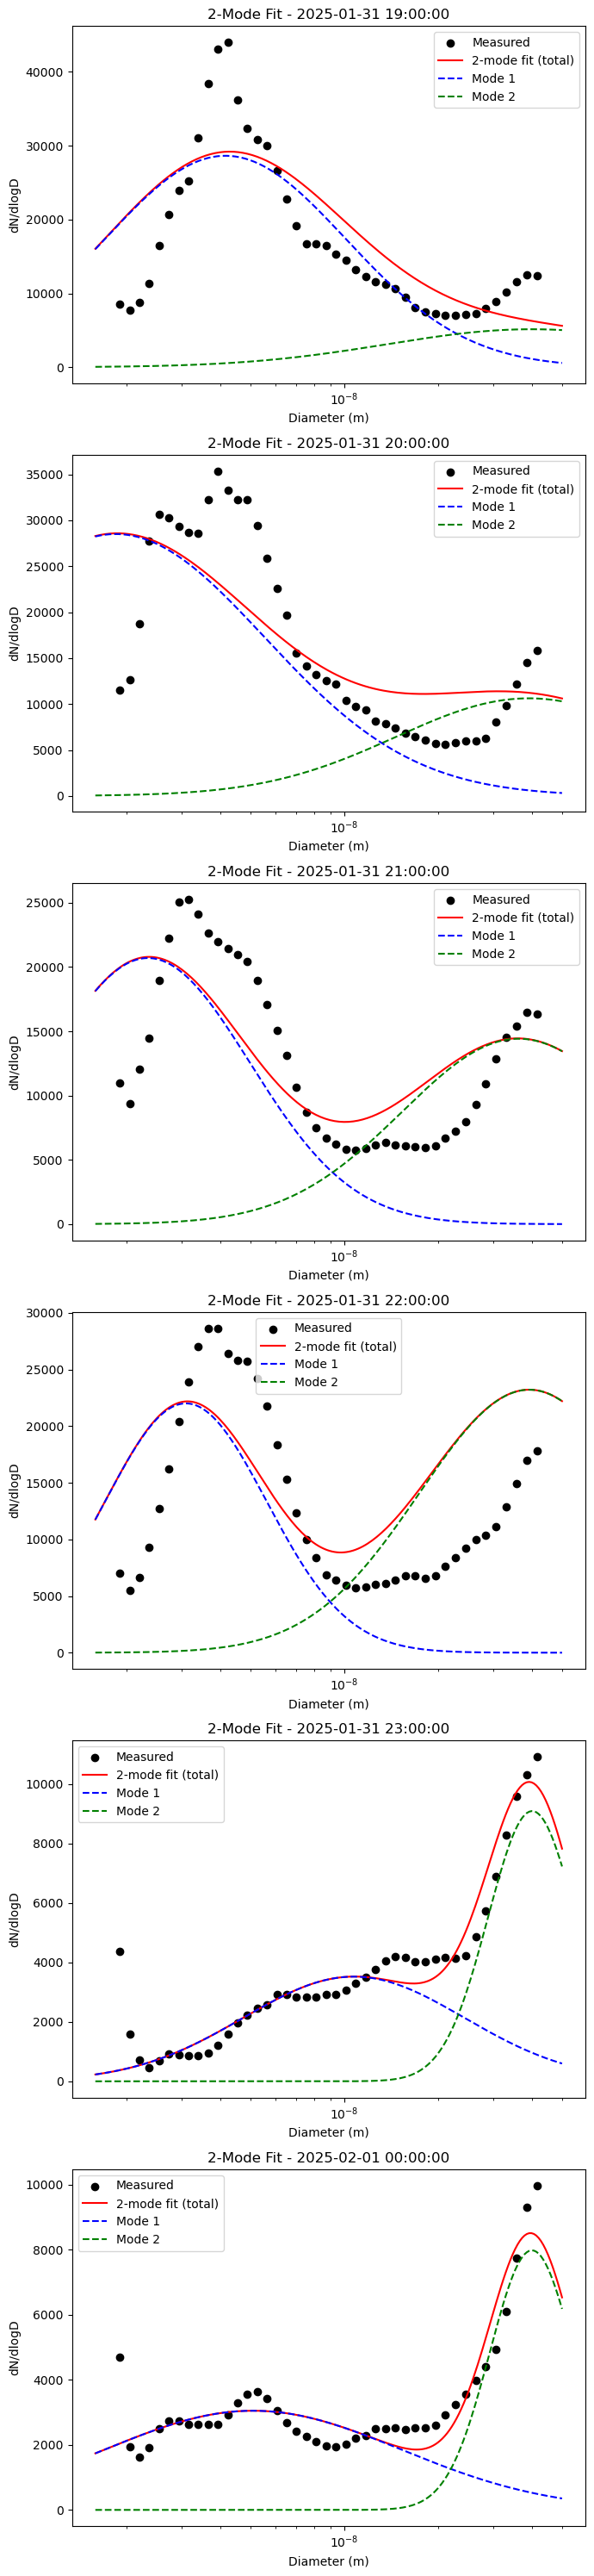

In [49]:
# Suppose 'df' is your size distribution DataFrame
# and 'fitted_df' is the output from fit_two_modes_all_times()

# 1) Pick a few times
times_to_plot = nais_pos_particles.index[-6:]  # first 3 times, for example
# or 
#times_to_plot = [nais_pos_particles.index[10], nais_pos_particles.index[50], nais_pos_particles.index[100]]

# 2) Plot
plot_fits_for_multiple_times(nais_pos_particles, fitted_params, times_to_plot)


In [50]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def lognormal(d, Dpg, Sg, N0):
    return (N0 / (np.sqrt(2*np.pi) * np.log(Sg))) * np.exp(
        -((np.log(d) - np.log(Dpg))**2) / (2*(np.log(Sg)**2))
    )

def onemodal_lognormal(d, Dpg1, Sg1, N01):
    return lognormal(d, Dpg1, Sg1, N01)

def twomodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02):
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02))

def aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

def fit_1_or_2_modes(d, y):
    """
    Try fitting one mode, then two modes. Pick the best by AIC.
    If 1-mode is best, second-mode params = NaN.
    """
    d = np.array(d, dtype=float)
    y = np.array(y, dtype=float)
    n = len(d)
    if n < 3:
        return {
            'n_modes': np.nan,
            'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
            'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan
        }
    
    # --- 1) Fit single-mode ---
    # Bounds for a single mode in [1 nm, 40 nm] = [1e-9, 4e-8]
    # Sg in [1.1, 3.0], N0 in [1, 1e10] (adjust as needed)
    p0_1 = [2e-8, 1.5, max(y)*10]  # initial guess: ~20 nm
    bounds_1 = (
        [1e-9, 1.1, 1],
        [4e-8, 3.0, 1e10]
    )
    try:
        popt1, _ = curve_fit(
            onemodal_lognormal, d, y,
            p0=p0_1, bounds=bounds_1
        )
        rss1 = np.sum((y - onemodal_lognormal(d, *popt1))**2)
        k1 = 3
        aic1 = aic(n, rss1, k1)
    except RuntimeError:
        popt1 = [np.nan, np.nan, np.nan]
        aic1 = np.inf
    
    # --- 2) Fit two-mode ---
    # Mode1: 1–20 nm, Mode2: 20–40 nm
    p0_2 = [1e-8, 1.5, max(y)*5,  3e-8, 1.5, max(y)*5]
    bounds_2 = (
        [1e-9, 1.1, 1,  2e-8, 1.1, 1],
        [2e-8, 3.0, 1e10, 4e-8, 3.0, 1e10]
    )
    try:
        popt2, _ = curve_fit(
            twomodal_lognormal, d, y,
            p0=p0_2, bounds=bounds_2
        )
        rss2 = np.sum((y - twomodal_lognormal(d, *popt2))**2)
        k2 = 6
        aic2 = aic(n, rss2, k2)
    except RuntimeError:
        popt2 = [np.nan]*6
        aic2 = np.inf
    
    # --- 3) Compare AIC ---
    if aic1 < aic2:
        # 1-mode is better
        return {
            'n_modes': 1,
            'Dpg1': popt1[0], 'Sg1': popt1[1], 'N01': popt1[2],
            'Dpg2': np.nan,  'Sg2': np.nan,   'N02': np.nan
        }
    else:
        # 2-mode is better (or tie -> default to 2-mode)
        return {
            'n_modes': 2,
            'Dpg1': popt2[0], 'Sg1': popt2[1], 'N01': popt2[2],
            'Dpg2': popt2[3], 'Sg2': popt2[4], 'N02': popt2[5]
        }


In [57]:
def plot_fitted_distribution(df, fitted_df, time, ax=None):
    """
    Plot the measured size distribution and the fitted lognormal(s) 
    for a single time step.
    
    Parameters
    ----------
    df : DataFrame
        index: DateTime
        columns: diameters (m)
        values: dN/dlogD
    fitted_df : DataFrame
        index: same as df
        columns: [n_modes, Dpg1, Sg1, N01, Dpg2, Sg2, N02] (or similar)
    time : Timestamp
        The specific time to plot
    ax : matplotlib Axes (optional)
        If None, creates a new figure.
    
    Returns
    -------
    ax : matplotlib Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,5))
    
    if time not in df.index or time not in fitted_df.index:
        raise ValueError(f"{time} not found in df/fitted_df index.")
    
    # Extract measured data for this time
    diameters = df.columns.astype(float)
    y_meas = df.loc[time].values
    
    # Mask NaNs in measured data
    mask = np.isfinite(y_meas)
    d_valid = diameters[mask]
    y_valid = y_meas[mask]
    
    # Get fitted parameters
    row = fitted_df.loc[time]
    n_modes = row.get('n_modes', np.nan)
    
    Dpg1 = row.get('Dpg1', np.nan)
    Sg1  = row.get('Sg1',  np.nan)
    N01  = row.get('N01',  np.nan)
    
    Dpg2 = row.get('Dpg2', np.nan)
    Sg2  = row.get('Sg2',  np.nan)
    N02  = row.get('N02',  np.nan)
    
    # Plot measured data
    ax.scatter(d_valid, y_valid, color='k', label='Measured')
    
    # Prepare a fine diameter grid for plotting the fitted curve
    if len(d_valid) > 0:
        d_min, d_max = d_valid.min(), d_valid.max()
        d_fine = np.logspace(np.log10(d_min/1.2), np.log10(d_max*1.2), 200)
    else:
        d_fine = np.logspace(-9, -7, 200)  # fallback if no valid data
    
    # Depending on n_modes, plot 1-mode or 2-mode fit
    if np.isnan(n_modes):
        ax.set_title(f"No valid fit: {time}")
    else:
        if int(n_modes) == 1:
            # If any param is NaN, skip
            if np.isnan([Dpg1, Sg1, N01]).any():
                ax.set_title(f"No valid 1-mode fit: {time}")
            else:
                fit_1 = onemodal_lognormal(d_fine, Dpg1, Sg1, N01)
                ax.plot(d_fine, fit_1, color='red', label='1-mode fit')
                ax.set_title(f"1-Mode Fit: {time}")
        elif int(n_modes) == 2:
            # If second mode is NaN, treat it like a 1-mode scenario
            if np.isnan([Dpg1, Sg1, N01, Dpg2, Sg2, N02]).any():
                ax.set_title(f"No valid 2-mode fit: {time}")
            else:
                fit_total = twomodal_lognormal(d_fine, Dpg1, Sg1, N01, Dpg2, Sg2, N02)
                fit_mode1 = onemodal_lognormal(d_fine, Dpg1, Sg1, N01)
                fit_mode2 = onemodal_lognormal(d_fine, Dpg2, Sg2, N02)
                
                ax.plot(d_fine, fit_total, 'r', label='2-mode fit (total)')
                ax.plot(d_fine, fit_mode1, 'b--', label='Mode 1')
                ax.plot(d_fine, fit_mode2, 'g--', label='Mode 2')
                ax.set_title(f"2-Mode Fit: {time}")
        else:
            ax.set_title(f"Unknown n_modes={n_modes} at {time}")
    
    ax.set_xscale('log')
    ax.set_xlabel('Diameter (m)')
    ax.set_ylabel('dN/dlogD')
    ax.legend()
    
    return ax


In [51]:
def fit_all_times_1_or_2(df):
    diameters_all = df.columns.astype(float)
    results = []
    for t in df.index:
        y_row = df.loc[t].values
        mask = np.isfinite(y_row)
        d_valid = diameters_all[mask]
        y_valid = y_row[mask]
        if len(d_valid) < 3:
            results.append({
                'n_modes': np.nan,
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan
            })
            continue
        try:
            res = fit_1_or_2_modes(d_valid, y_valid)
        except (RuntimeError, ValueError):
            res = {
                'n_modes': np.nan,
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan
            }
        results.append(res)
    return pd.DataFrame(results, index=df.index)


In [53]:
fit_all_times_1_or_2(nais_pos_particles)

,n_modes,Dpg1,Sg1,N01,Dpg2,Sg2,N02
time,,,,,,,
2024-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-31 20:00:00,1.0,3.948637e-09,2.639632,66481.518659,NaN,NaN,NaN
2025-01-31 21:00:00,2.0,2.945620e-09,1.837056,33174.056030,3.918784e-08,1.989994,27289.211354
2025-01-31 22:00:00,2.0,3.152523e-09,1.632225,29785.233235,3.901421e-08,2.131654,31799.412394


In [58]:
def plot_fits_for_multiple_times(df, fitted_df, times_list):
    """
    Create subplots for each time in `times_list`, showing 
    measured data and the 1- or 2-mode fit (whichever is present).
    
    Parameters
    ----------
    df : DataFrame
    fitted_df : DataFrame
    times_list : list of timestamps (subset of df.index)
    """
    n_times = len(times_list)
    fig, axes = plt.subplots(n_times, 1, figsize=(7, 4*n_times), sharex=False)
    
    if n_times == 1:
        # If there's only one time, axes is not a list
        axes = [axes]
    
    for ax, time in zip(axes, times_list):
        plot_fitted_distribution(df, fitted_df, time, ax=ax)
    
    plt.tight_layout()
    plt.show()


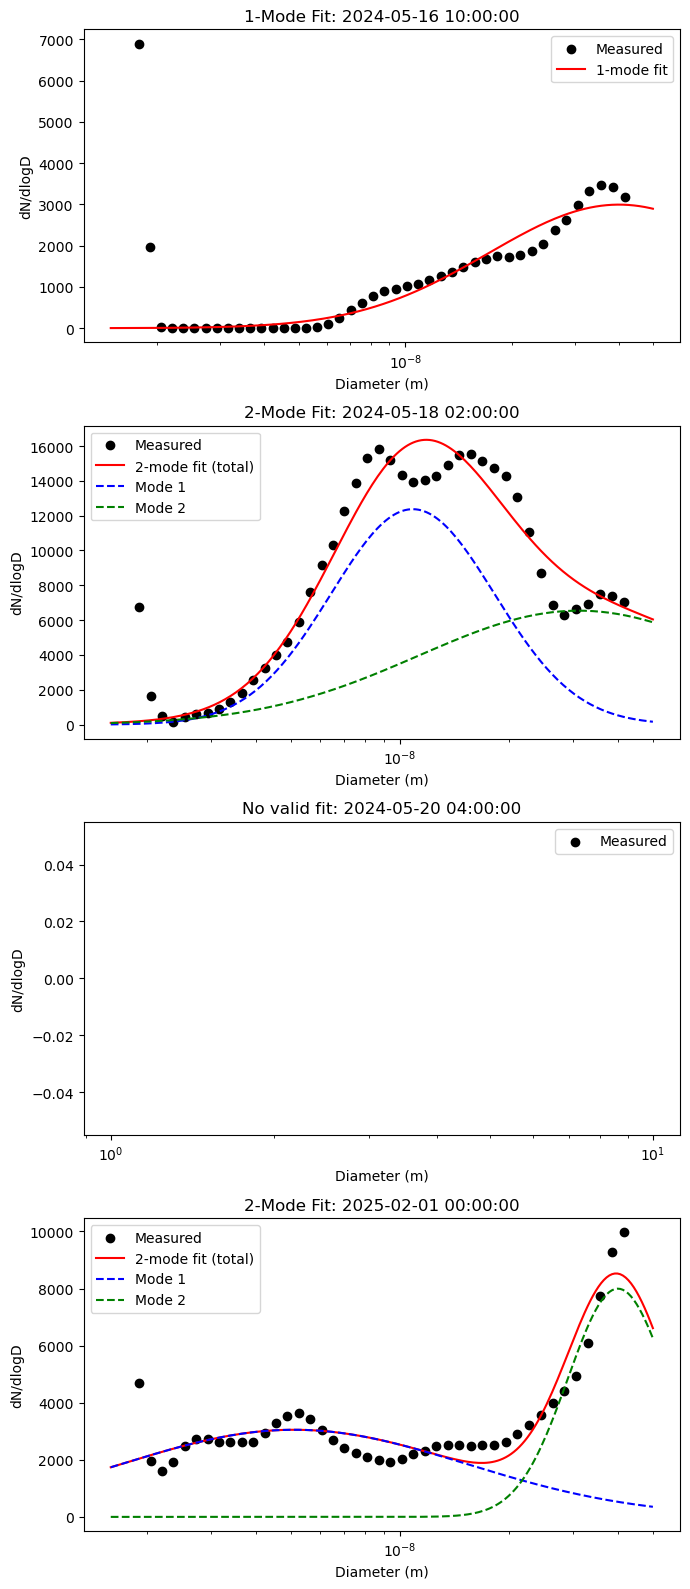

In [59]:
# Supposenais_pos_particles is your DataFrame of measured data,
# and fitted_df is the DataFrame with columns:
# [n_modes, Dpg1, Sg1, N01, Dpg2, Sg2, N02].

# 1) Choose a few times to plot
times_to_plot = [
   nais_pos_particles.index[10],
   nais_pos_particles.index[50],
   nais_pos_particles.index[100],
   nais_pos_particles.index[-1]
]

# 2) Plot them
plot_fits_for_multiple_times(nais_pos_particles, one_or_two,times_to_plot)


In [52]:
popt, pcov = curve_fit(
    twomodal_lognormal, d, y,
    p0=p0, bounds=bounds,
    sigma=1/np.maximum(y, 1),  # just a rough weighting
    absolute_sigma=False
)


NameError: name 'd' is not defined

In [33]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def lognormal(d, Dpg, Sg, N0):
    """
    Single lognormal mode in dN/dlogD form.
    d   : diameter (m)
    Dpg : geometric mean diameter (m)
    Sg  : geometric standard deviation (dimensionless)
    N0  : total number concentration for this mode
    """
    return (N0 / (np.sqrt(2*np.pi) * np.log(Sg))) * np.exp(
        -((np.log(d) - np.log(Dpg))**2) / (2*(np.log(Sg)**2))
    )

def threemodal_lognormal(
    d, 
    Dpg1, Sg1, N01,   # nucleation
    Dpg2, Sg2, N02,   # Aitken
    Dpg3, Sg3, N03    # accumulation
):
    """
    Sum of three lognormal modes.
    """
    return (
        lognormal(d, Dpg1, Sg1, N01) +
        lognormal(d, Dpg2, Sg2, N02) +
        lognormal(d, Dpg3, Sg3, N03)
    )

def fit_three_modes(d, y):
    """
    Fit a 3-mode lognormal distribution to the data (d, y),
    forcing each mode to remain in a specific diameter range:
      - Mode1 (nucleation):   1–20 nm
      - Mode2 (Aitken):      20–100 nm
      - Mode3 (accumulation): 100–1000 nm
    
    Parameters
    ----------
    d : array of diameters (meters!)
    y : array of dN/dlogD
    
    Returns
    -------
    popt : best-fit parameters [Dpg1, Sg1, N01, Dpg2, Sg2, N02, Dpg3, Sg3, N03]
    pcov : covariance matrix from curve_fit
    """
    # Convert to numpy arrays
    d = np.asarray(d, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Initial guesses (p0):
    #   - Dpg1 ~ 1e-8 (10 nm), Dpg2 ~ 5e-8 (50 nm), Dpg3 ~ 3e-7 (300 nm)
    #   - Sg ~ 1.5
    #   - N0 ~ e.g. 10x max(y) for each mode
    p0 = [
        1.0e-8, 1.5, max(y)*10,   # nucleation
        5.0e-8, 1.5, max(y)*10,   # Aitken
        3.0e-7, 1.5, max(y)*10    # accumulation
    ]
    
    # Bounds in meters:
    #   Dpg1 in [1e-9, 2e-8], Dpg2 in [2e-8, 1e-7], Dpg3 in [1e-7, 1e-6]
    #   Sg in [1.1, 3.0]
    #   N0 in [1, 1e10] (adjust as needed!)
    lower_bounds = [
        1e-9, 1.1, 1,    # Dpg1, Sg1, N01
        2e-8, 1.1, 1,    # Dpg2, Sg2, N02
        1e-7, 1.1, 1     # Dpg3, Sg3, N03
    ]
    upper_bounds = [
        2e-8, 3.0, 1e10,
        1e-7, 3.0, 1e10,
        1e-6, 3.0, 1e10
    ]
    
    # Fit using curve_fit
    popt, pcov = curve_fit(
        threemodal_lognormal, d, y,
        p0=p0, 
        bounds=(lower_bounds, upper_bounds)
    )
    return popt, pcov


In [34]:
def fit_three_modes_all_times(df):
    """
    df: DataFrame
        - index: DateTime
        - columns: diameters (in meters)
        - values: dN/dlogD
    Returns: DataFrame with fitted parameters for each time
    """
    diameters_all = df.columns.values.astype(float)  # ensure numeric
    
    results = []
    for time in df.index:
        y_row = df.loc[time].values
        # Filter out NaNs or inf
        mask = np.isfinite(y_row)
        d_valid = diameters_all[mask]
        y_valid = y_row[mask]
        
        # If not enough points remain, store NaN
        if len(d_valid) < 5:
            results.append({
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
                'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan
            })
            continue
        
        # Attempt the 3-mode fit
        try:
            popt, pcov = fit_three_modes(d_valid, y_valid)
            results.append({
                'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
                'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5],
                'Dpg3': popt[6], 'Sg3': popt[7], 'N03': popt[8]
            })
        except RuntimeError:
            # Fit failed
            results.append({
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
                'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan
            })
    
    return pd.DataFrame(results, index=df.index)


In [35]:

# Example usage:
fitted_df = fit_three_modes_all_times(nais_pos_particles)
fitted_df.head()


ValueError: `x0` is infeasible.

In [31]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import math

# --- 1) Define lognormal functions ---

def lognormal(d, Dpg, Sg, N0):
    return (N0 / (np.sqrt(2*np.pi) * np.log(Sg))) * np.exp(
        -((np.log(d) - np.log(Dpg))**2) / (2*(np.log(Sg)**2))
    )

def onemodal_lognormal(d, Dpg1, Sg1, N01):
    return lognormal(d, Dpg1, Sg1, N01)

def twomodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02):
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02))

def threemodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02, Dpg3, Sg3, N03):
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02)
          + lognormal(d, Dpg3, Sg3, N03))

# Simple AIC function
def aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

# --- 2) Single-timestep fit function ---

def fit_lognorm_modes_for_timestep(d, y, max_modes=3):
    """
    Fit up to 3 lognormal modes to a single size distribution (d, y).
    Returns a dict with the chosen number of modes (1-3), the best-fit parameters,
    and the model's AIC. Unused mode parameters are set to NaN.
    """
    from scipy.optimize import curve_fit

    # Convert to numpy arrays
    d = np.array(d, dtype=float)
    y = np.array(y, dtype=float)
    n = len(d)

    # If not enough points, return NaNs immediately
    if n < 3:
        return {
            'n_modes': np.nan,
            'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
            'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
            'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan,
            'AIC': np.nan
        }

    # Naive initial guesses and bounds (adjust for your dataset!)
    guess_1 = [np.median(d), 1.5, max(y)*10.0]
    bounds_1 = ([1e-9, 1.1, 1], [2e-8, 3.0, 1e-7])

    q25, q75 = np.quantile(d, [0.25, 0.75])
    guess_2 = [q25, 1.5, max(y)*5,  q75, 1.5, max(y)*5]
    bounds_2 = (
        [1e-9, 1.1, 1,   1e-9, 1.1, 1],
        [2e-8, 3.0, 1e-7, 2e-8, 3.0, 1e-7]
    )

    q25, q50, q75 = np.quantile(d, [0.25, 0.50, 0.75])
    guess_3 = [
        q25, 1.5, max(y)*3,
        q50, 1.5, max(y)*3,
        q75, 1.5, max(y)*3
    ]
    bounds_3 = (
        [1e-9, 1.1, 1,   1e-9, 1.1, 1,   1e-9, 1.1, 1],
        [2e-8, 3.0, 1e-7, 2e-8, 3.0, 1e-7, 2e-8, 3.0, 1e-7]
    )

    fit_results = []

    # 1-mode fit
    if max_modes >= 1:
        try:
            popt1, pcov1 = curve_fit(
                onemodal_lognormal, d, y,
                p0=guess_1, bounds=bounds_1
            )
            rss1 = np.sum((y - onemodal_lognormal(d, *popt1))**2)
            k1 = 3
            aic1 = aic(n, rss1, k1)
            fit_results.append(("1-mode", k1, popt1, rss1, aic1))
        except RuntimeError:
            pass

    # 2-mode fit
    if max_modes >= 2:
        try:
            popt2, pcov2 = curve_fit(
                twomodal_lognormal, d, y,
                p0=guess_2, bounds=bounds_2
            )
            rss2 = np.sum((y - twomodal_lognormal(d, *popt2))**2)
            k2 = 6
            aic2 = aic(n, rss2, k2)
            fit_results.append(("2-mode", k2, popt2, rss2, aic2))
        except RuntimeError:
            pass

    # 3-mode fit
    if max_modes >= 3:
        try:
            popt3, pcov3 = curve_fit(
                threemodal_lognormal, d, y,
                p0=guess_3, bounds=bounds_3
            )
            rss3 = np.sum((y - threemodal_lognormal(d, *popt3))**2)
            k3 = 9
            aic3 = aic(n, rss3, k3)
            fit_results.append(("3-mode", k3, popt3, rss3, aic3))
        except RuntimeError:
            pass

    # If all fits failed, return NaN
    if not fit_results:
        return {
            'n_modes': np.nan,
            'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
            'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
            'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan,
            'AIC': np.nan
        }

    # Pick best fit by AIC
    best_fit = min(fit_results, key=lambda x: x[4])
    model_name, k, popt, rss, best_aic = best_fit

    if model_name == "1-mode":
        return {
            'n_modes': 1,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
            'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan,
            'AIC': best_aic
        }
    elif model_name == "2-mode":
        return {
            'n_modes': 2,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5],
            'Dpg3': np.nan,  'Sg3': np.nan,  'N03': np.nan,
            'AIC': best_aic
        }
    else:  # "3-mode"
        return {
            'n_modes': 3,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5],
            'Dpg3': popt[6], 'Sg3': popt[7], 'N03': popt[8],
            'AIC': best_aic
        }

# --- 3) Loop over all times, skipping NaNs column-by-column ---

def fit_all_times(df, max_modes=3, min_points=5):
    """
    Loop over each timestamp (row) in df and fit up to 'max_modes' lognormal modes.
    For each row, ignore columns with NaNs.
    Returns a DataFrame with columns for each mode's parameters.
    
    Parameters
    ----------
    df : DataFrame
        index: DateTime (each row is a measurement time)
        columns: diameters (float, in ascending order)
        values: dN/dlogD at each diameter
    max_modes : int
        1, 2, or 3 (maximum number of modes to attempt)
    min_points : int
        minimum number of valid diameter points required to attempt a fit

    Returns
    -------
    results_df : DataFrame
        index: same as df (timestamps)
        columns: [n_modes, Dpg1, Sg1, N01, Dpg2, Sg2, N02, Dpg3, Sg3, N03, AIC]
    """
    # Convert the column names to numeric diameters
    diameters_all = df.columns.astype(float)
    
    results = []
    for t in df.index:
        # Extract the entire row of data
        y_row = df.loc[t].values  # This may contain NaNs

        # Build a mask for finite data only
        mask = np.isfinite(y_row)
        
        # Filter diameters and y accordingly
        d_valid = diameters_all[mask]
        y_valid = y_row[mask]
        
        # If there aren't enough points left, skip or fill with NaN
        if len(d_valid) < min_points:
            results.append({
                'n_modes': np.nan,
                'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
                'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
                'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan,
                'AIC': np.nan
            })
            continue
        
        # Otherwise, attempt to fit
        res = fit_lognorm_modes_for_timestep(d_valid, y_valid, max_modes=max_modes)
        results.append(res)
    
    results_df = pd.DataFrame(results, index=df.index)
    return results_df


In [32]:

# Example usage:
fitted_params = fit_all_times(nais_pos_particles, max_modes=3)
fitted_params.head()


ValueError: Each lower bound must be strictly less than each upper bound.

In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import math
import warnings

In [20]:
def lognormal(d, Dpg, Sg, N0):
    """
    Single lognormal mode.
    Parameters:
      d   : diameters (array)
      Dpg : geometric mean diameter
      Sg  : geometric standard deviation
      N0  : total number concentration for this mode
    Returns:
      dN/dlogD (array)
    """
    # Avoid log(0) if any diameter is 0
    return (N0 / (np.sqrt(2*np.pi) * np.log(Sg))) * np.exp(
        -((np.log(d) - np.log(Dpg))**2) / (2*(np.log(Sg)**2))
    )


In [21]:
def onemodal_lognormal(d, Dpg1, Sg1, N01):
    return lognormal(d, Dpg1, Sg1, N01)

def twomodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02):
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02))

def threemodal_lognormal(d, Dpg1, Sg1, N01, Dpg2, Sg2, N02, Dpg3, Sg3, N03):
    return (lognormal(d, Dpg1, Sg1, N01)
          + lognormal(d, Dpg2, Sg2, N02)
          + lognormal(d, Dpg3, Sg3, N03))


In [22]:
def aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k


In [23]:
def fit_lognorm_modes_for_timestep(d, y, max_modes=3):
    """
    Fit up to 3 lognormal modes to a single size distribution (d, y).
    Returns a dict with the chosen number of modes (1-3), the best-fit parameters,
    and the model's AIC. Unused mode parameters are set to NaN.
    
    Parameters
    ----------
    d : array
        Diameters (independent variable)
    y : array
        Measured dN/dlogD (dependent variable)
    max_modes : int (1 to 3)
        The maximum number of modes to try.
        
    Returns
    -------
    result : dict
        {
          'n_modes': 1, 2, or 3,
          'Dpg1': ..., 'Sg1': ..., 'N01': ...,
          'Dpg2': ..., 'Sg2': ..., 'N02': ...,
          'Dpg3': ..., 'Sg3': ..., 'N03': ...,
          'AIC': ...
        }
        If fewer than 3 modes are chosen, missing mode parameters are NaN.
    """
    # Ensure arrays are float
    d = np.array(d, dtype=float)
    y = np.array(y, dtype=float)
    n = len(d)
    
    # Some very naive initial guesses & parameter bounds:
    # You should tailor these for your dataset!
    
    # Single-mode guess
    # Guess geometric mean diameter ~ median(d), Sg ~ 1.5, N0 ~ max(y)*some_width
    # (We multiply max(y) by a factor to guess total number.)
    guess_1 = [
        np.median(d),   # Dpg1
        1.5,            # Sg1
        max(y) * 10.0   # N01
    ]
    bounds_1 = (
        [1e-9, 1.1, 1],     # lower
        [1e-6,  3.0, 1e8]   # upper
    )
    
    # Two-mode guess: we guess diameters near 25% and 75% quantiles
    # as naive "small mode" vs "large mode", plus some typical Sg, N0
    q25, q75 = np.quantile(d, [0.25, 0.75])
    guess_2 = [
        q25, 1.5, max(y)*5,   # (Dpg1, Sg1, N01)
        q75, 1.5, max(y)*5    # (Dpg2, Sg2, N02)
    ]
    bounds_2 = (
        [1e-9, 1.1, 1,  1e-9, 1.1, 1],
        [1e-6, 3.0, 1e8, 1e-6, 3.0, 1e8]
    )
    
    # Three-mode guess: pick 1/4, 1/2, 3/4 quantiles as naive mode positions
    q25, q50, q75 = np.quantile(d, [0.25, 0.50, 0.75])
    guess_3 = [
        q25, 1.5, max(y)*3,
        q50, 1.5, max(y)*3,
        q75, 1.5, max(y)*3
    ]
    bounds_3 = (
        [1e-9, 1.1, 1,  1e-9, 1.1, 1,  1e-9, 1.1, 1],
        [1e-6, 3.0, 1e8, 1e-6, 3.0, 1e8, 1e-6, 3.0, 1e8]
    )
    
    # We'll store (model_name, param_count, popt, pcov, RSS, AIC_value)
    fit_results = []
    
    # 1-mode fit
    if max_modes >= 1:
        try:
            popt1, pcov1 = curve_fit(
                onemodal_lognormal, d, y,
                p0=guess_1, bounds=bounds_1
            )
            residuals = y - onemodal_lognormal(d, *popt1)
            rss1 = np.sum(residuals**2)
            k1 = 3  # number of parameters
            aic1 = aic(n, rss1, k1)
            fit_results.append(("1-mode", k1, popt1, pcov1, rss1, aic1))
        except RuntimeError:
            pass
    
    # 2-mode fit
    if max_modes >= 2:
        try:
            popt2, pcov2 = curve_fit(
                twomodal_lognormal, d, y,
                p0=guess_2, bounds=bounds_2
            )
            residuals = y - twomodal_lognormal(d, *popt2)
            rss2 = np.sum(residuals**2)
            k2 = 6  # number of parameters
            aic2 = aic(n, rss2, k2)
            fit_results.append(("2-mode", k2, popt2, pcov2, rss2, aic2))
        except RuntimeError:
            pass
    
    # 3-mode fit
    if max_modes >= 3:
        try:
            popt3, pcov3 = curve_fit(
                threemodal_lognormal, d, y,
                p0=guess_3, bounds=bounds_3
            )
            residuals = y - threemodal_lognormal(d, *popt3)
            rss3 = np.sum(residuals**2)
            k3 = 9  # number of parameters
            aic3 = aic(n, rss3, k3)
            fit_results.append(("3-mode", k3, popt3, pcov3, rss3, aic3))
        except RuntimeError:
            pass
    
    # If all fits failed, return NaN for everything:
    if len(fit_results) == 0:
        return {
            'n_modes': np.nan,
            'Dpg1': np.nan, 'Sg1': np.nan, 'N01': np.nan,
            'Dpg2': np.nan, 'Sg2': np.nan, 'N02': np.nan,
            'Dpg3': np.nan, 'Sg3': np.nan, 'N03': np.nan,
            'AIC': np.nan
        }
    
    # Pick the best fit by min AIC
    best_fit = min(fit_results, key=lambda x: x[5])  # x[5] is AIC
    model_name, k, popt, pcov, rss, best_aic = best_fit
    
    # Format output
    if model_name == "1-mode":
        return {
            'n_modes': 1,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': np.nan,  'Sg2': np.nan,  'N02': np.nan,
            'Dpg3': np.nan,  'Sg3': np.nan,  'N03': np.nan,
            'AIC': best_aic
        }
    elif model_name == "2-mode":
        return {
            'n_modes': 2,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5],
            'Dpg3': np.nan,  'Sg3': np.nan,  'N03': np.nan,
            'AIC': best_aic
        }
    else:  # "3-mode"
        return {
            'n_modes': 3,
            'Dpg1': popt[0], 'Sg1': popt[1], 'N01': popt[2],
            'Dpg2': popt[3], 'Sg2': popt[4], 'N02': popt[5],
            'Dpg3': popt[6], 'Sg3': popt[7], 'N03': popt[8],
            'AIC': best_aic
        }


In [24]:
def fit_all_times(df, max_modes=3):
    """
    Loop over each timestamp (row) in df and fit up to 'max_modes' lognormal modes.
    Returns a DataFrame with columns for each mode's parameters.
    
    df: DataFrame
        index: DateTime (each row is a measurement time)
        columns: diameters in ascending order (units: meters)
        values: dN/dlogD at each diameter
    max_modes: 1 to 3
    
    Returns
    -------
    results_df: DataFrame
        index: same as df (timestamps)
        columns: [n_modes, Dpg1, Sg1, N01, Dpg2, Sg2, N02, Dpg3, Sg3, N03, AIC]
    """
    # Convert the column names to numeric diameters
    diameters = df.columns.astype(float)
    
    results = []
    for t in df.index:
        y = df.loc[t].values
        res = fit_lognorm_modes_for_timestep(diameters, y, max_modes=max_modes)
        results.append(res)
    
    results_df = pd.DataFrame(results, index=df.index)
    return results_df


In [25]:

# Example usage:
fitted_params = fit_all_times(nais_pos_particles, max_modes=3)
fitted_params


ValueError: array must not contain infs or NaNs

In [26]:
# Check each row for non-finite data
bad_rows = nais_pos_particles.index[~np.isfinite(nais_pos_particles).all(axis=1)]
if len(bad_rows) > 0:
    print("Rows with NaN or Inf values:")
    print(bad_rows)


Rows with NaN or Inf values:
DatetimeIndex(['2024-05-16 00:00:00', '2024-05-16 01:00:00',
               '2024-05-16 02:00:00', '2024-05-16 03:00:00',
               '2024-05-16 04:00:00', '2024-05-16 05:00:00',
               '2024-05-16 06:00:00', '2024-05-16 07:00:00',
               '2024-05-16 08:00:00', '2024-05-16 09:00:00',
               ...
               '2025-01-31 15:00:00', '2025-01-31 16:00:00',
               '2025-01-31 17:00:00', '2025-01-31 18:00:00',
               '2025-01-31 19:00:00', '2025-01-31 20:00:00',
               '2025-01-31 21:00:00', '2025-01-31 22:00:00',
               '2025-01-31 23:00:00', '2025-02-01 00:00:00'],
              dtype='datetime64[ns]', name='time', length=6265, freq=None)


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def detect_npf_events_df(df, window_hours=3, min_growth_rate=0.5, r2_threshold=0.7):
    """
    Detect NPF (banana) events in the particle size distribution data and
    return a DataFrame with start and end times and corresponding mode diameters.
    
    Parameters:
      df               : pandas DataFrame with a DateTime index and columns as diameters (e.g., in nm).
                         The cell values are particle concentrations.
      window_hours     : Time window (in hours) over which to test for a consistent mode shift.
      min_growth_rate  : Minimum slope (growth rate in nm per hour) to consider an event.
      r2_threshold     : Minimum R-squared value for the regression to ensure a good fit.
    
    Returns:
      event_df: pandas DataFrame with columns:
                'start_time', 'start_mode', 'end_time', 'end_mode', 'growth_rate', 'r2'
    """
    # Ensure column names are numeric diameters.
    diameters = np.array(df.columns, dtype=float)
    
    # Calculate the mode diameter (the diameter with maximum concentration) for each timestamp.
    mode_diams = df.apply(lambda row: diameters[np.argmax(row.values)], axis=1)
    df = df.copy()
    df['mode_diam'] = mode_diams

    event_list = []
    times = df.index
    n = len(times)
    
    # Loop over each timestamp as a potential start of an event.
    for i in range(n):
        start_time = times[i]
        end_time = start_time + pd.Timedelta(hours=window_hours)
        window_df = df.loc[start_time:end_time]
        if len(window_df) < 2:
            continue

        # Convert time stamps to numeric values (hours since the window start).
        t_numeric = (window_df.index - window_df.index[0]).total_seconds() / 3600.0
        mode_values = window_df['mode_diam'].values
        
        # Perform linear regression.
        reg_result = linregress(t_numeric, mode_values)
        slope = reg_result.slope      # growth rate in nm per hour
        r_value = reg_result.rvalue
        r2 = r_value ** 2
        diam_increase = mode_values[-1] - mode_values[0]
        
        # Check if the slope (growth rate) and the R-squared exceed thresholds.
        if slope >= min_growth_rate and r2 >= r2_threshold and diam_increase >= 5:
            event_list.append({
                'start_time': start_time,
                'start_mode': mode_values[0],
                'end_time': window_df.index[-1],
                'end_mode': mode_values[-1],
                'growth_rate': slope,
                'r2': r2
            })
    
    event_df = pd.DataFrame(event_list)
    return event_df

def plot_banana(df, event=None):
    """
    Plot a contour (banana) plot of the particle concentration data.
    
    Parameters:
      df   : DataFrame with a DateTime index and diameter columns.
             (It may also include the extra column 'mode_diam'.)
      event: Optional dict to highlight on the plot (e.g., from detect_npf_events_df).
    """
    plt.figure(figsize=(12, 6))
    
    # Remove 'mode_diam' column if present.
    if 'mode_diam' in df.columns:
        conc_df = df.drop(columns=['mode_diam'])
    else:
        conc_df = df
        
    diameters = np.array(conc_df.columns, dtype=float)
    
    # Create a meshgrid for contour plotting.
    X, Y = np.meshgrid(diameters, conc_df.index)
    Z = conc_df.values  # Particle concentration data.
    
    cs = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(cs, label='Concentration')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Time')
    plt.title('Banana Plot of Particle Size Distribution')
    
    # If an event is provided, mark the start and end times.
    if event is not None:
        start = event['start_time']
        end = event['end_time']
        plt.axhline(start, color='red', linestyle='--', label='Event Start')
        plt.axhline(end, color='orange', linestyle='--', label='Event End')
        plt.legend()
        
    plt.show()


Detected NPF (banana) events:
Empty DataFrame
Columns: []
Index: []


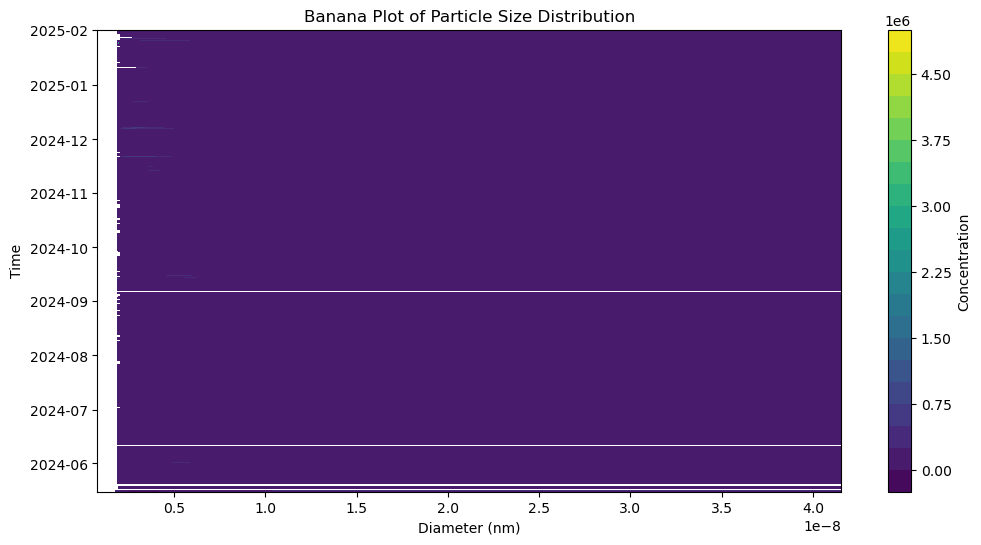

In [18]:

# Example usage:
# Assume your DataFrame is named "nais_pos_particles" with a DateTime index and diameter columns (e.g., '3', '4', '5', ...).

# Detect events and store them in a DataFrame.
event_df = detect_npf_events_df(nais_pos_particles, window_hours=3, min_growth_rate=0.1, r2_threshold=0.5)
print("Detected NPF (banana) events:")
print(event_df)

# Optionally, plot the banana plot and highlight the first detected event.
if not event_df.empty:
    first_event = event_df.iloc[0].to_dict()
    plot_banana(nais_pos_particles, event=first_event)
else:
    plot_banana(nais_pos_particles)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_npf_events(df, window_hours=6, corr_threshold=0.7, min_diam_increase=5):
    """
    Detect NPF (banana) events in the particle size distribution data.

    Parameters:
      df               : pandas DataFrame with datetime index, columns as diameters (e.g., in nm), 
                         and values as concentrations.
      window_hours     : Time window (in hours) over which to test for a consistent mode shift.
      corr_threshold   : Minimum Pearson correlation between time and mode diameter in the window.
      min_diam_increase: Minimum increase (in nm) in the mode diameter over the window.

    Returns:
      events: List of tuples (start_time, end_time) indicating detected event periods.
    """
    # Make sure the column names (diameters) are numeric.
    diameters = np.array(df.columns, dtype=float)
    
    # Compute the mode diameter for each time stamp: the diameter with maximum concentration.
    mode_diams = df.apply(lambda row: diameters[np.argmax(row.values)], axis=1)
    df = df.copy()
    df['mode_diam'] = mode_diams

    events = []
    times = df.index
    n = len(times)
    
    # Loop over each time stamp as a possible event start.
    for i in range(n):
        start_time = times[i]
        end_time = start_time + pd.Timedelta(hours=window_hours)
        window_df = df.loc[start_time:end_time]
        if len(window_df) < 2:
            continue
        # Convert time stamps in the window to numeric values (seconds since the window start).
        t_numeric = (window_df.index - window_df.index[0]).total_seconds().astype(float)
        mode_values = window_df['mode_diam'].values
        # Avoid division by zero
        if np.std(t_numeric) == 0 or np.std(mode_values) == 0:
            continue
        # Compute the Pearson correlation coefficient between time and mode diameter.
        corr = np.corrcoef(t_numeric, mode_values)[0, 1]
        diam_increase = mode_values[-1] - mode_values[0]
        # Check if both the correlation and the overall increase exceed the thresholds.
        if corr >= corr_threshold and diam_increase >= min_diam_increase:
            events.append((start_time, window_df.index[-1]))
    return events

def plot_banana(df, event=None):
    """
    Plot a contour (banana) plot of the particle concentration data.
    
    Parameters:
      df   : DataFrame with datetime index and diameter columns.
             (It may also contain the extra column 'mode_diam'.)
      event: Optional tuple (start_time, end_time) to highlight on the plot.
    """
    plt.figure(figsize=(12,6))
    
    # Get the diameter values (assuming they are all but the last column if 'mode_diam' exists)
    if 'mode_diam' in df.columns:
        conc_df = df.drop(columns=['mode_diam'])
    else:
        conc_df = df
    diameters = np.array(conc_df.columns, dtype=float)
    
    # Create a mesh for time and diameter.
    X, Y = np.meshgrid(diameters, conc_df.index)
    Z = conc_df.values  # Concentration data
    
    # Create a filled contour plot.
    cs = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(cs, label='Concentration')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Time')
    plt.title('Banana Plot of Particle Size Distribution')
    
    # If an event is provided, mark the start and end times.
    if event:
        plt.axhline(event[0], color='red', linestyle='--', label='Event Start')
        plt.axhline(event[1], color='orange', linestyle='--', label='Event End')
        plt.legend()
    plt.show()


Detected NPF (banana) events:


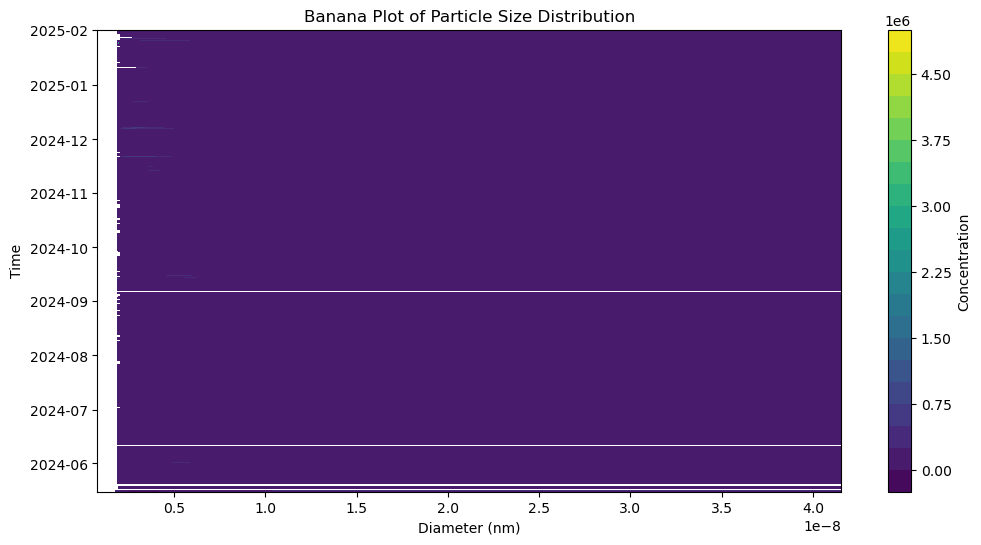

In [7]:

# Example usage:
# Assume your DataFrame is named "nais_pos_particles" with a DateTime index and diameter columns (e.g., '3', '4', '5', ...)

# Detect events:
events = detect_npf_events(nais_pos_particles, window_hours=6, corr_threshold=0.7, min_diam_increase=5)
print("Detected NPF (banana) events:")
for ev in events:
    print(f"Start: {ev[0]}, End: {ev[1]}")

# Optionally, plot the banana plot and highlight the first detected event.
if events:
    plot_banana(nais_pos_particles, event=events[0])
else:
    plot_banana(nais_pos_particles)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_npf_events_df(df, window_hours=6, corr_threshold=0.7, min_diam_increase=5):
    """
    Detect NPF (banana) events in the particle size distribution data and
    return a DataFrame with start and end times and corresponding mode diameters.
    
    Parameters:
      df               : pandas DataFrame with a DateTime index and columns as diameters (e.g., in nm).
                         The cell values are particle concentrations.
      window_hours     : Time window (in hours) over which to test for a consistent mode shift.
      corr_threshold   : Minimum Pearson correlation between time and mode diameter in the window.
      min_diam_increase: Minimum increase (in nm) in the mode diameter over the window.
    
    Returns:
      event_df: pandas DataFrame with columns:
                'start_time', 'start_mode', 'end_time', 'end_mode'
    """
    # Ensure column names are numeric diameters.
    diameters = np.array(df.columns, dtype=float)
    
    # Calculate the mode diameter (the diameter with maximum concentration) for each time stamp.
    mode_diams = df.apply(lambda row: diameters[np.argmax(row.values)], axis=1)
    df = df.copy()
    df['mode_diam'] = mode_diams

    event_list = []
    times = df.index
    n = len(times)
    
    # Loop over each timestamp as a potential start of an event.
    for i in range(n):
        start_time = times[i]
        end_time = start_time + pd.Timedelta(hours=window_hours)
        window_df = df.loc[start_time:end_time]
        if len(window_df) < 2:
            continue

        # Convert time stamps to numeric values (seconds since the window start).
        t_numeric = (window_df.index - window_df.index[0]).total_seconds().astype(float)
        mode_values = window_df['mode_diam'].values
        
        # Avoid windows with zero variation.
        if np.std(t_numeric) == 0 or np.std(mode_values) == 0:
            continue
        
        # Compute the Pearson correlation coefficient between time and mode diameter.
        corr = np.corrcoef(t_numeric, mode_values)[0, 1]
        diam_increase = mode_values[-1] - mode_values[0]
        
        # If the correlation and the overall increase exceed the thresholds, flag an event.
        if corr >= corr_threshold and diam_increase >= min_diam_increase:
            event_list.append({
                'start_time': start_time,
                'start_mode': mode_values[0],
                'end_time': window_df.index[-1],
                'end_mode': mode_values[-1]
            })
    
    event_df = pd.DataFrame(event_list)
    return event_df

def plot_banana(df, event=None):
    """
    Plot a contour (banana) plot of the particle concentration data.
    
    Parameters:
      df   : DataFrame with a DateTime index and diameter columns.
             (It may also include the extra column 'mode_diam'.)
      event: Optional tuple or dict to highlight on the plot (e.g., from detect_npf_events_df).
    """
    plt.figure(figsize=(12, 6))
    
    # Remove 'mode_diam' column if present.
    if 'mode_diam' in df.columns:
        conc_df = df.drop(columns=['mode_diam'])
    else:
        conc_df = df
        
    diameters = np.array(conc_df.columns, dtype=float)
    
    # Create a meshgrid for contour plotting.
    X, Y = np.meshgrid(diameters, conc_df.index)
    Z = conc_df.values  # Particle concentration data.
    
    cs = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(cs, label='Concentration')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Time')
    plt.title('Banana Plot of Particle Size Distribution')
    
    # If an event is provided, mark the start and end times.
    if event is not None:
        if isinstance(event, dict):
            start = event['start_time']
            end = event['end_time']
        else:  # assume event is a tuple (start_time, end_time)
            start, end = event
        plt.axhline(start, color='red', linestyle='--', label='Event Start')
        plt.axhline(end, color='orange', linestyle='--', label='Event End')
        plt.legend()
        
    plt.show()


Detected NPF (banana) events:
Empty DataFrame
Columns: []
Index: []


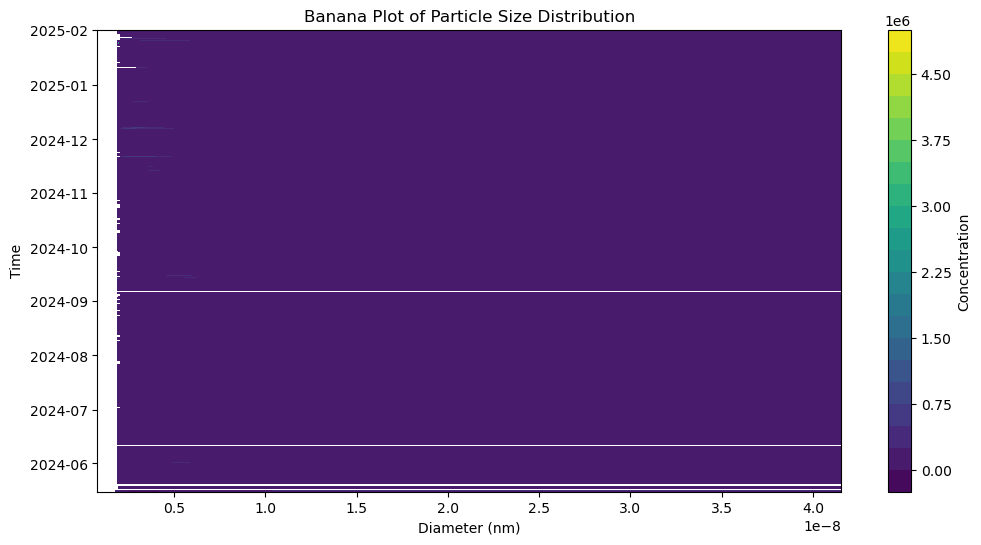

In [12]:

# Example usage:
# Assume your DataFrame is named "nais_pos_particles" with a DateTime index and columns that are diameters (e.g., '3', '4', '5', ...).

# Detect events and store them in a DataFrame.
event_df = detect_npf_events_df(nais_pos_particles, window_hours=3, corr_threshold=0.5, min_diam_increase=1)
print("Detected NPF (banana) events:")
print(event_df)

# Optionally, plot the banana plot and highlight the first detected event.
if not event_df.empty:
    first_event = event_df.iloc[0].to_dict()
    plot_banana(nais_pos_particles, event=first_event)
else:
    plot_banana(nais_pos_particles)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Python version of the NAIS/PSM processing and nucleation timing code.
This code uses pandas, numpy, and matplotlib to mimic the R script steps.
Adjust variable names and parameters as needed.
"""


# =============================================================================
# 1. Data Preparation and Integration
# =============================================================================

# Assume that:
# - nais_n is a pandas DataFrame containing NAIS data.
#   The first two columns are (for example) date/time and a secondary variable,
#   and columns 3 onward are particle concentration measurements.
# - nais_diam is a 1D numpy array of diameters.
#
# For example, you might load your data as:
# nais_n = pd.read_csv("nais_n.csv", parse_dates=[0])
# nais_diam = np.loadtxt("nais_diam.txt")
#
# Here, we assume they are already in the environment.

# For demonstration, here is a dummy initialization:
# (Remove or replace with your actual data-loading code)
# nais_n = pd.read_csv("nais_n.csv", parse_dates=['date'])
# nais_diam = np.array([...])

# --- Integration step ---
# Compute the logarithmic differences between consecutive diameters
log_dp = np.log10(nais_diam[1:]) - np.log10(nais_diam[:-1])
# Append the 27th element (index 26) to maintain the same length
log_dp = np.concatenate([log_dp, [log_dp[26]]])

# Multiply each measurement column (all except the first two) by the corresponding weight.
# Here we assume that nais_n columns are ordered so that:
# columns 0 and 1: non-measurement (e.g., date and another id)
# columns 2 onward: measurements (with length equal to len(log_dp))
m1 = nais_n.copy()  # starting copy

# Multiply measurement columns by the corresponding log_dp values.
# We use broadcasting on the DataFrame values.
m1.iloc[:, 2:] = m1.iloc[:, 2:].values * log_dp

# Create a new column "date.start" by subtracting 120 seconds from the first column.
# (Assuming the first column is datetime; otherwise adjust accordingly.)
if np.issubdtype(m1.iloc[:, 0].dtype, np.datetime64):
    m1['date.start'] = m1.iloc[:, 0] - pd.Timedelta(seconds=120)
else:
    m1['date.start'] = m1.iloc[:, 0] - 120

# =============================================================================
# 2. Averaging the Data (Aggregation into 6-minute intervals)
# =============================================================================

# We want to aggregate all columns except the first and the last (date.start)
# using a grouping variable based on the "date.start" column.
# The grouping variable is defined as the numeric time minus its remainder modulo 360.

# If date.start is datetime, convert it to seconds since epoch.
if np.issubdtype(m1['date.start'].dtype, np.datetime64):
    m1['time_sec'] = m1['date.start'].apply(lambda x: x.timestamp())
else:
    m1['time_sec'] = m1['date.start']

# Create the group key (floor time to nearest 360 seconds)
m1['group_key'] = m1['time_sec'] - (m1['time_sec'] % 360)

# The aggregation is performed on all columns except the first and the last column.
# (In the original R code, these are m1[,-c(1, ncol(m1))]. Adjust as needed.)
# Here, we assume that columns 1 (0-indexed) through the second-to-last are to be averaged.
# (If the first column is a datetime that you do not wish to average, exclude it.)
agg_columns = m1.columns[1:-2]  # adjust if needed

# Group by the group_key and calculate the mean for each group (automatically skipping NaN)
m1_ave = m1.groupby('group_key')[agg_columns].mean().reset_index()

# Add back a "date" column computed by converting group_key + 360 seconds to datetime.
m1_ave['date'] = pd.to_datetime(m1_ave['group_key'] + 360, unit='s')

# =============================================================================
# 3. Integration of Specific Channels
# =============================================================================

# In the R code, the integrated signal is the row-sum of columns 7 and 8 of m1.ave.
# (Remember: R is 1-indexed; in Python these are likely at positions 6 and 7.)
m1_int = pd.DataFrame()
m1_int['date'] = m1_ave['date']
m1_int['int.1.44.1.66'] = m1_ave.iloc[:, 6] + m1_ave.iloc[:, 7]

# =============================================================================
# 4. Determining Nucleation Timing for NAIS Data
# =============================================================================

# Split m1_int by day (using Julian day, i.e. day-of-year)
m1_int['julian'] = m1_int['date'].dt.strftime('%j')
groups = dict(tuple(m1_int.groupby('julian')))

# Prepare an empty DataFrame for the nucleation timing results.
npf_timing_ave = pd.DataFrame(columns=["b[start.npf, 1]", "b[stop.npf, 1]"])

# Loop through each day (the variable i will correspond to the day index as in the R code)
for i, (julian, b) in enumerate(groups.items(), start=1):
    # Compute noise from early-morning data: use data where hour is between 0 and 4.
    morning_mask = (b['date'].dt.hour >= 0) & (b['date'].dt.hour < 4)
    # Calculate the mean absolute difference (diff() produces NaN for the first element)
    noise = b.loc[morning_mask, 'int.1.44.1.66'].diff().abs().mean(skipna=True)
    
    # Special case: for day 6, use nighttime data (hour > 21) if needed.
    if i == 6:
        night_mask = b['date'].dt.hour > 21
        noise = b.loc[night_mask, 'int.1.44.1.66'].diff().abs().mean(skipna=True)
    
    # Skip this day if noise cannot be computed
    if pd.isna(noise):
        continue

    # Set threshold ratio (adjust for specific days)
    th_ratio = 20
    if i in [15, 19]:
        th_ratio = 10
    th = th_ratio * noise
    count_fact = 5
    above_th = 0

    # Drop rows with missing integrated values
    b = b.dropna(subset=['int.1.44.1.66']).reset_index(drop=True)

    # --- Forward loop to find nucleation start ---
    start_npf = None
    for k in range(len(b)):
        if b.loc[k, 'int.1.44.1.66'] > th:
            above_th += 1
            if above_th > count_fact:
                start_idx = k - count_fact - 1
                if start_idx >= 0:
                    start_npf = b.loc[start_idx, 'date']
                break
        else:
            above_th = 0

    # --- Backward loop to find nucleation stop ---
    th_ratio_back = 15
    if i == 15:
        th_ratio_back = 10
    th_back = th_ratio_back * noise
    above_th = 0
    stop_npf = None
    for k in range(len(b) - 1, -1, -1):
        if b.loc[k, 'int.1.44.1.66'] > th_back:
            above_th += 1
            if above_th > count_fact:
                stop_idx = k + count_fact + 1
                if stop_idx < len(b):
                    stop_npf = b.loc[stop_idx, 'date']
                break
        else:
            above_th = 0

    # Append the start and stop times (if found) to the results DataFrame
    npf_timing_ave = npf_timing_ave.append(
        {"b[start.npf, 1]": start_npf, "b[stop.npf, 1]": stop_npf},
        ignore_index=True
    )

    # --- Plotting for quality control ---
    plt.figure(figsize=(8, 8))
    plt.plot(b['date'], b['int.1.44.1.66'], marker='o', markersize=0.3, linestyle='-', label='Integrated signal')
    plt.ylabel("Total count for 1.66+1.44 nm negative ions")
    plt.xlabel("")
    plt.title("NAIS neg ions " + b['date'].iloc[0].strftime("%Y%m%d"))
    # Highlight points above threshold in red.
    above_mask = b['int.1.44.1.66'] > th
    plt.plot(b.loc[above_mask, 'date'], b.loc[above_mask, 'int.1.44.1.66'], 'o', color='red', markersize=0.8)
    if start_npf is not None:
        plt.axvline(start_npf, linestyle="--", color="red")
    if stop_npf is not None:
        plt.axvline(stop_npf, linestyle="--", color="green")
    plt.savefig("npf_start_stop_nais_neg" + b['date'].iloc[0].strftime("%Y%m%d") + ".png", dpi=300)
    plt.close()

# Remove rows with both start and stop missing and filter out non‐nucleation days.
npf_timing_ave = npf_timing_ave.dropna(how="all")
remove_dates = ["20141128", "20141223", "20141212"]
npf_timing_ave = npf_timing_ave[
    ~npf_timing_ave["b[start.npf, 1]"].dt.strftime("%Y%m%d").isin(remove_dates)
].reset_index(drop=True)


In [ ]:

# =============================================================================
# 5. NPF Timing for PSM Data
# =============================================================================

# Assume psm_6min is a pandas DataFrame with a datetime column (e.g., 'date')
# and a measurement column for 1.1 nm particles (here assumed to be named "PSM_1.1").
#
# For example:
# psm_6min = pd.read_csv("psm_6min.csv", parse_dates=['date'])

# Split psm_6min by day (using Julian day)
psm_6min['julian'] = psm_6min['date'].dt.strftime('%j')
groups_psm = dict(tuple(psm_6min.groupby('julian')))
npf_timing_psm = pd.DataFrame(columns=["b[start.npf, 1]", "b[stop.npf, 1]"])
psm_col = "PSM_1.1"  # Name of the measurement column in psm_6min

for i, (julian, b) in enumerate(groups_psm.items(), start=1):
    # Calculate noise from early morning (0-4) for the PSM column.
    morning_mask = (b['date'].dt.hour >= 0) & (b['date'].dt.hour < 4)
    noise = b.loc[morning_mask, psm_col].diff().abs().mean(skipna=True)

    # Skip if noise cannot be computed.
    if pd.isna(noise):
        continue

    th_ratio = 40
    th = th_ratio * noise
    count_fact = 5
    above_th = 0

    b = b.dropna(subset=[psm_col]).reset_index(drop=True)

    # Forward loop for nucleation start
    start_npf = None
    for k in range(len(b)):
        if b.loc[k, psm_col] > th:
            above_th += 1
            if above_th > count_fact:
                start_idx = k - count_fact - 1
                if start_idx >= 0:
                    start_npf = b.loc[start_idx, 'date']
                break
        else:
            above_th = 0

    # Backward loop for nucleation stop
    above_th = 0
    stop_npf = None
    for k in range(len(b)-1, -1, -1):
        if b.loc[k, psm_col] > th:
            above_th += 1
            if above_th > count_fact:
                stop_idx = k + count_fact + 1
                if stop_idx < len(b):
                    stop_npf = b.loc[stop_idx, 'date']
                break
        else:
            above_th = 0

    # Manual adjustments for certain days
    if i == 2:
        start_npf = b.loc[60, 'date'] if len(b) > 60 else start_npf
        stop_npf = b.loc[93, 'date'] if len(b) > 93 else stop_npf
    if i == 3:
        start_npf = b.loc[51, 'date'] if len(b) > 51 else start_npf
        stop_npf = b.loc[92, 'date'] if len(b) > 92 else stop_npf
    if i == 4:
        start_npf = b.loc[67, 'date'] if len(b) > 67 else start_npf
        stop_npf = b.loc[100, 'date'] if len(b) > 100 else stop_npf

    npf_timing_psm = npf_timing_psm.append(
        {"b[start.npf, 1]": start_npf, "b[stop.npf, 1]": stop_npf},
        ignore_index=True
    )

    # Plotting the PSM data for quality control
    plt.figure(figsize=(8, 8))
    plt.plot(b['date'], b[psm_col], marker='o', markersize=0.3, linestyle='-', label='PSM signal')
    plt.ylabel("Total count for PSM 1.1 nm particles")
    plt.xlabel("")
    plt.title("PSM 1.1 nm " + b['date'].iloc[0].strftime("%Y%m%d"))
    above_mask = b[psm_col] > th
    plt.plot(b.loc[above_mask, 'date'], b.loc[above_mask, psm_col], 'o', color='red', markersize=0.8)
    if start_npf is not None:
        plt.axvline(start_npf, linestyle="--", color="red")
    if stop_npf is not None:
        plt.axvline(stop_npf, linestyle="--", color="green")
    plt.show()  # or use plt.savefig(...) to save the figure


In [ ]:

# =============================================================================
# 6. Creating Continuous Time Series Relative to Nucleation Events
# =============================================================================

# Create a complete time series at one-minute resolution for the period of interest.
m1_full = pd.DataFrame({
    'date': pd.date_range(start="2014-11-29 00:00:00", end="2014-12-26 00:00:00", freq='min')
})

# --- For Integrated NAIS Data ---
nucl_time = pd.DataFrame()
for idx, row in npf_timing_ave.iterrows():
    # Extract the day corresponding to the nucleation event
    day_str = row["b[start.npf, 1]"].strftime("%Y%m%d")
    day_data = m1_full[m1_full['date'].dt.strftime("%Y%m%d") == day_str].copy()
    # Create a column of time relative to nucleation start (as a Timedelta)
    day_data['nucl.time'] = day_data['date'] - row["b[start.npf, 1]"]
    nucl_time = pd.concat([nucl_time, day_data], ignore_index=True)

# --- For Negative Ions ---
# (Select specific events by their indices; note that R uses 1-indexing.)
selected_indices_neg = [3, 4, 5, 16, 17, 18]  # Adjust indices as needed
nucl_time_neg = pd.DataFrame()
for i in selected_indices_neg:
    row = npf_timing_ave.iloc[i]
    day_str = row["b[start.npf, 1]"].strftime("%Y%m%d")
    day_data = m1_full[m1_full['date'].dt.strftime("%Y%m%d") == day_str].copy()
    day_data['nucl.time'] = day_data['date'] - row["b[start.npf, 1]"]
    nucl_time_neg = pd.concat([nucl_time_neg, day_data], ignore_index=True)

# --- For Positive Ions ---
# (Again, adjust the indices to match your data; R code uses c(2,3,8:16) which in 0-indexed Python becomes:)
selected_indices_pos = [1, 2] + list(range(7, 16))
nucl_time_pos = pd.DataFrame()
for i in selected_indices_pos:
    row = npf_timing_ave.iloc[i]
    day_str = row["b[start.npf, 1]"].strftime("%Y%m%d")
    day_data = m1_full[m1_full['date'].dt.strftime("%Y%m%d") == day_str].copy()
    day_data['nucl.time'] = day_data['date'] - row["b[start.npf, 1]"]
    nucl_time_pos = pd.concat([nucl_time_pos, day_data], ignore_index=True)

# =============================================================================
# 7. (Optional) Quality Control and Manual Adjustments at Second Resolution
# =============================================================================

# If you have updated nucleation timing information (e.g., stored in a DataFrame npf_timing_fixed_2019)
# and you want to create a second-resolution time series, you can do something like:

# Assume npf_timing_fixed_2019 is a DataFrame with at least:
#   - "b[start.npf, 1]": nucleation start datetime,
#   - a column (say, "type") with values "neg" or "pos" indicating the measurement type.
#
# For example, if you want to process negative ion events:
m1_sec = pd.DataFrame({
    'date': pd.date_range(start="2014-11-29 00:00:00", end="2014-12-26 00:00:00", freq='S')
})
nucl_time_neg_2019 = pd.DataFrame()
# Filter for negative ion events in npf_timing_fixed_2019 (adjust column names as needed)
for idx, row in npf_timing_fixed_2019[npf_timing_fixed_2019['type'] == "neg"].iterrows():
    day_str = row["b[start.npf, 1]"].strftime("%Y%m%d")
    day_data = m1_sec[m1_sec['date'].dt.strftime("%Y%m%d") == day_str].copy()
    day_data['nucl.time'] = day_data['date'] - row["b[start.npf, 1]"]
    nucl_time_neg_2019 = pd.concat([nucl_time_neg_2019, day_data], ignore_index=True)

# Similarly, you can process positive ion events.

# =============================================================================
# End of Script
# =============================================================================

print("Processing complete. Check generated plots and DataFrames for nucleation timing.")
